In [2]:
# !pip install lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 99.3 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=200745d57d48551035788e0fb338f22b27f6bde69c0adf0f79b650b5db36978a
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Created wheel for memoization: 

In [3]:
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [41]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from lightkurve import search_targetpixelfile

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from google.colab import drive
drive.mount('/content/drive')
plt.rcParams['text.usetex'] = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
tpf = search_targetpixelfile('KIC 11904151', author="Kepler", cadence="long", quarter=1).download()
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
intensity = lc.flux.value
time = lc.time.value

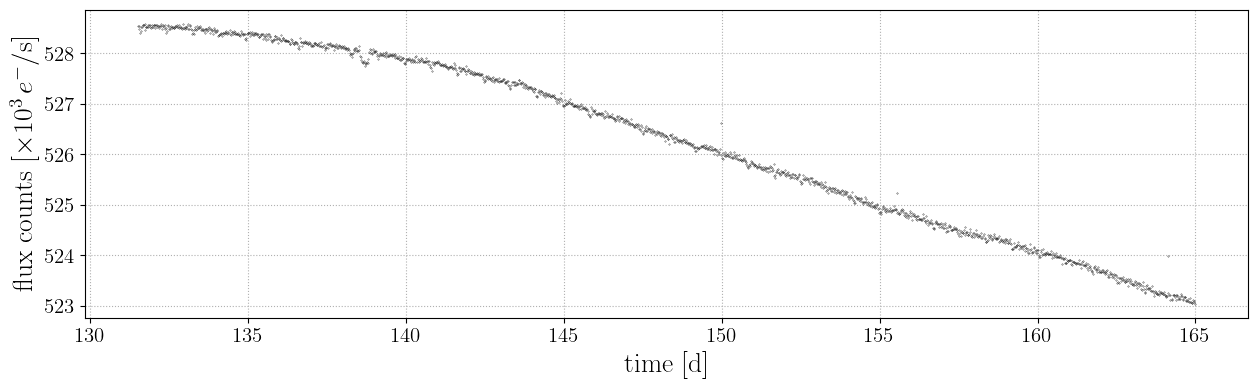

In [42]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.grid(which="both", ls=":")
ax.set_xlabel(r"time [$\rm d$]", fontsize=20)
ax.set_ylabel(r"flux counts [$\times 10^3 \, e^-/\rm{s}$]", fontsize=20)
ax.plot(time, intensity/1000, "k.", markersize=0.5)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/kepler_lc.png", dpi=600, bbox_inches="tight")

In [7]:
lc_reversed = lc.flux.value[::-1]

In [8]:
window = 11
pad_size = (window - 1)//2
lc_padded = np.zeros(len(lc.flux.value) + 2*pad_size)
lc_padded[pad_size:pad_size + len(lc)] = lc.flux.value

In [9]:
lc_padded[:pad_size] = lc_reversed[-pad_size:]
lc_padded[-pad_size:] = lc_reversed[:pad_size]

In [10]:
lc_padded

array([528435.6875, 528402.5   , 528470.125 , ..., 523087.0625,
       523118.9375, 523050.375 ])

In [11]:
# weight(x) = e^(-0.5 * (x / sigma)**2)
def weights(sigma):
  center = window // 2
  x = np.arange(window) - center #index - center,, centering indices around 0
  weights = np.exp(-0.5 * (x / sigma)**2) # e^...
  return weights / np.sum(weights) # weights add up to 1

In [12]:
sigma = 3.0
smoothed_lc = np.zeros(len(lc.flux.value))
for i, _ in enumerate(smoothed_lc):
    captured_window = lc_padded[i:i+window]
    smoothed_lc[i] = np.dot(captured_window, weights(sigma))

In [13]:
assert len(smoothed_lc) == len(lc) == len(time)  # error if not True

In [14]:
# gaussian filter
smoothed_lc_gauss = gaussian_filter1d(lc.flux.value, sigma=3)  # sigma = smoothing level

**Now add errors!**

In [15]:
err = intensity/10000

**Quantities that measure light:**

* Brightness
* Intensity
* Specific intensity
* Flux
* Specific flux
* Integrated flux
* Counts
* Integrated counts

All of these have different units. Make sure you understand what "525 000" measures!!!


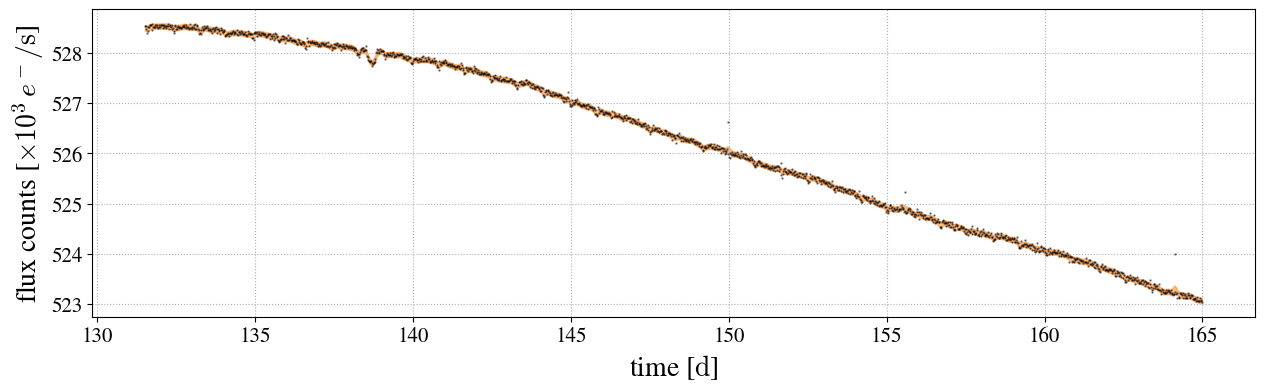

In [37]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.grid(which="both", ls=":")
ax.set_xlabel(r"time [$\rm d$]", fontsize=20)
ax.set_ylabel(r"flux counts [$\times 10^3 \, e^-/\rm{s}$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

upper_boundary = smoothed_lc + err
lower_boundary = smoothed_lc - err
ax.fill_between(time, lower_boundary/1000, upper_boundary/1000, color="tab:orange", alpha=0.5)
ax.plot(time, intensity/1000, "ko", markersize=0.7, alpha=0.5)

fig.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/kepler_lc_error.png", dpi=600, bbox_inches="tight")

- Quote the uncertainties of the (light) measurements.

**Now we do residual analysis!**

In [17]:
# residuals
residuals = 1 - (smoothed_lc / smoothed_lc_gauss)

# residual analysis
from scipy.stats import gaussian_kde

res_arr = np.linspace(1e5*residuals.min(), 1e5*residuals.max(), 500)
F = gaussian_kde(1e5*residuals)

In [18]:
residuals.mean(), residuals.std()

(np.float64(-2.3992236378560103e-11), np.float64(4.028316983269708e-06))

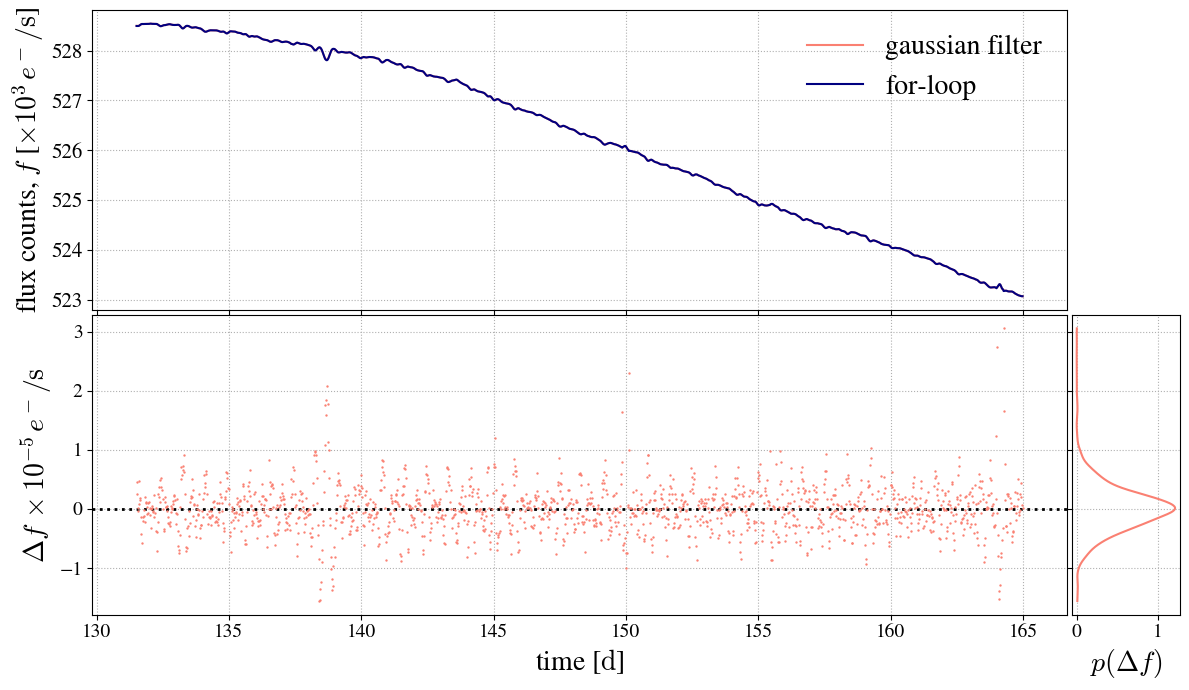

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", width_ratios=[0.9, 0.1], figsize=(12, 7))
ax1, ax2, ax3, ax4 = axs.flatten()
ax2.axis("off")

ax1.grid(which="both", ls=":")
ax3.grid(which="both", ls=":")
ax4.grid(which="both", ls=":")

ax1.tick_params(axis='both', which='major', labelsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax4.tick_params(axis='both', which='major', labelsize=14)

ax3.set_xlabel(r"time [$\rm d$]", fontsize=20)
ax4.set_xlabel(r"$p(\Delta f)$", fontsize=20)

ax1.set_ylabel(r"flux counts, $f$ [$\times 10^3 \, e^-/\rm{s}$]", fontsize=20)
ax3.set_ylabel(r"$\Delta f \, \times 10^{-5} \, e^-/\rm{s}$", fontsize=20)


ax1.plot(time, smoothed_lc_gauss/1000, c="salmon", label="gaussian filter")
ax1.plot(time, smoothed_lc/1000, c="navy", label="for-loop")

ax3.axhline(0, color="k", linestyle=":", linewidth=2)
ax3.plot(time, 1e5*residuals, "o", markersize=0.7, c="salmon")

ax4.plot(F(res_arr), res_arr, c="salmon")

ax1.legend(loc="best", frameon=False, fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout(h_pad=0, w_pad=0)

fig.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/forloop", dpi=600, bbox_inches="tight")

plt.show()

In [20]:
# normalising data
normalised_lc = smoothed_lc / np.max(smoothed_lc) # max flux of 1

# detrending data
trend = savgol_filter(normalised_lc, window_length=101, polyorder=2)
detrended_lc = normalised_lc / trend

/tmp/ipython-input-40-457899992.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="best", frameon=False, fontsize=20)


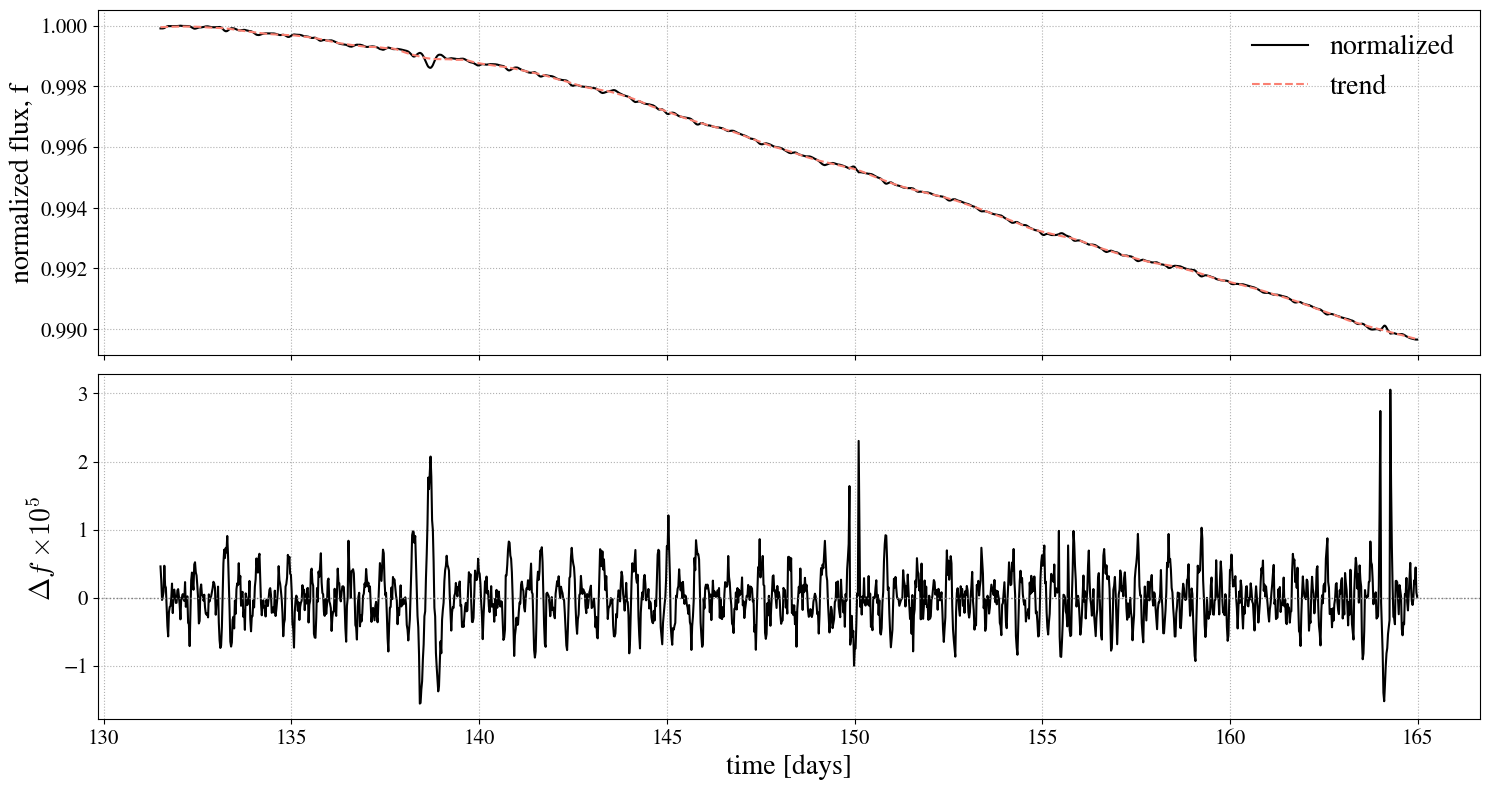

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)

ax1.set_ylabel("normalized flux, f", fontsize=20)
ax1.grid(which="both", ls=":")
ax1.plot(time, normalised_lc, c="black", label="normalized")
ax1.plot(time, trend, color="salmon", linestyle="--", label="trend")
ax1.legend(loc="best", frameon=False, fontsize=20)

ax2.plot(time, 1e5 * residuals, 'k-')
ax2.axhline(0, color='grey', linestyle=':', linewidth=1)
ax2.grid(which="both", ls=":")
ax2.set_xlabel(r"time [days]", fontsize=20)
ax2.set_ylabel(r"$\Delta f$ $\times 10^5$ ", fontsize=20)
ax2.ticklabel_format(style='plain', axis='y')
ax2.legend(loc="best", frameon=False, fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

fig.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/normalised.png", dpi=600, bbox_inches="tight")

fig.tight_layout(h_pad=1)
plt.show()

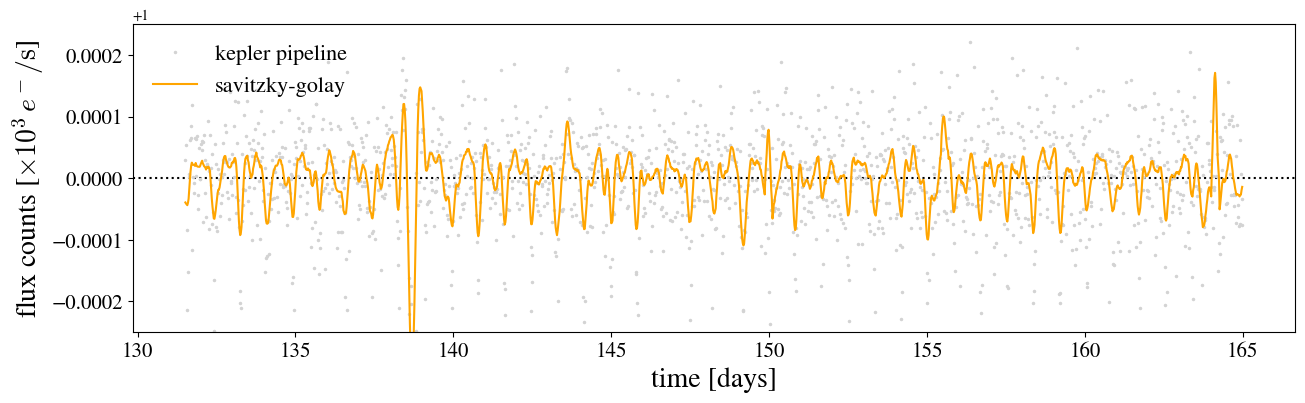

In [39]:

flattened_lc = lc.flatten()
flattened_lc_flux = flattened_lc.flux.value
flattened_time = flattened_lc.time.value

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("time [days]", fontsize=20)
ax.set_ylabel(r"flux counts [$\times 10^3 \, e^-/\rm{s}$]", fontsize=20)
ax.axhline(1, c="k", ls=":")

ax.plot(flattened_time, flattened_lc_flux, 'o', c="lightgray", label="kepler pipeline", alpha=1, markersize=1.5)
ax.plot(flattened_time, detrended_lc, c="orange", label="savitzky-golay")

ax.set_ylim(0.99975, 1.00025)
ax.legend(loc="best", frameon=False, fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig("/content/drive/MyDrive/lumiere physics research - sampurna/python code/residuals.png", dpi=600, bbox_inches="tight")

plt.show()

In [23]:
np.save("/content/drive/MyDrive/lumiere physics research - sampurna/python code/detrended_lc.npy", detrended_lc)
np.save("/content/drive/MyDrive/lumiere physics research - sampurna/python code/time.npy", time)